# Problem 1: Bayesian Optimization By Hand

While there are a variety of libraries that can be used to perform Bayesian optimization, it is important to understand the underlying process. In this problem, you will build a bayesian optimization pipeline by hand and use it to find 15 of the top 5% of materials in a dataset.

Taken as a whole, this problem may seem daunting. However, when broken into its components it is quite manageable. Recall the Bayesian optimization flow chart from the lectures that details to core components of the a bayesian optimization pipeline. Rather than trying to solve this problem all in one shot, we recommend building the pipeline one component at a time and making sure you understand it before moving on to the next component.

You are given the crossed barrel dataset, which shows the toughness of materials as a function of several 3D printer parameters. For learning purposes, we are going to pretend that we don't know the optimal parameters in advance and perform a simulated optimzation campaign to find them. Your task is to start with 5 random samples from the data and use Bayesian optimization to find the top 5% of candidates in the data. Use the gaussain process model included in the `scikit-learn` package as your surrogate model. We would like you to perform the optimization with two different acquisition functions: expected improvement and upper confidence bound. You will need to implement these acquisition functions by hand (don't worry it's easy). Your termination criteria will be when you have found at least 15 candidates from the top 5% of the materials in the dataset.

Your code will likely get very messy as you experiment and learn how to implement these components. However, clean code is an expectation in professional settings. Therefore, we are requiring that your final code by clean and commented (this includes function explanations) upon submission. 3pts will be assigned to this. If you are unsure if your code is clean enough, ask a TA or instructor for feedback.

**Specific Tasks**

Please show the following for both UCB and EI cases:
- How many iterations it took to find 15 candidates (should be less than 150)
- A plot of the 15 candidates you found relative to the entire dataset
- A plot of the number of candidates you found as a function of iteation count
- A plot of the best candidate you found as a function of the iteration count

Finally provide some commentary on the performance of your optimization campaigns. What surprised you about the results? What would you do differently if you were to do this in a real experimental setting?

In [16]:
# Import statements 
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import product
from scipy.stats import norm
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# set my random seed here 
random_seed = 42

In [17]:
#   xy(df,ycol_name)
#
#   just so I don't have to write two lines of code when setting X and y from a dataset
#
#   pass a dataframe and the target or y column name and it will return X and y dataframes 
#
#   some error checking
#
def xy(df,ycol_name):
    # Error checking
    if not isinstance(df,pd.DataFrame):
        raise ValueError("df must be a DataFrame object.")
    
    if not isinstance(ycol_name,str):
        raise ValueError("ycol_name must be a string object.")

    # pull X and y from my data_pool
    X = df.drop(columns=[ycol_name])
    y = df[[ycol_name]]
    return X, y


In [18]:
"""
    generateGP(X,y)

    returns a trained gp model witn the trained X and y scalers that were used
    
    gp model is implemented as GaussianProcessingRegressor from scikit-learn
    using a C * RBF kernel

    no hyperparameter optimization is performed

    The scaling was suggested by ChatGPT4
    It is my understanding that gaussian process models do not need the y data scaled
    I removed it and seemed to have worse results so I left it in

"""
def generateGP(X, y):
    
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X must be a DataFrame object. Use generateGP(data_pool)")
    if not isinstance(y, pd.DataFrame):
        raise ValueError("y must be a DataFrame object. Use generateGP(data_pool)")
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))  # Ensure y is 2D for scaling

    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)
    
    gp.fit(X_scaled, y_scaled)  # Use ravel() to convert y to 1D for fitting
    
    return gp, scaler_X, scaler_y


In [19]:
"""
    get_ucb(gp_model, X_scaler, X, kappa=2)

    accepts a trained gp model, an X_scaler, X data, and a kappa value     
    Intention is that the X data is the entire parameter space available 
    That is how it is used in this program
    Then it returns the acq_values for each possible set of parameters for the problem.

    The kappa of 2 is intended to balance exploration vs exploitation
    Can pass the value to the get_ucb in the actual optimization loop if desired

    kappa of 2 was chosen to be fairly balanced, but still promote exploration

"""
def get_ucb(gp_model, X_scaler, X, kappa=2):
    # Transform X using the scaler
    X_scaled = X_scaler.transform(X)
    
    # Compute mean and standard deviation predictions on the scaled data
    mean, std = gp_model.predict(X_scaled, return_std=True)
    
    # Compute Upper Confidence Bound
    acq_values = mean + kappa * std
    
    return acq_values


In [20]:
"""
    expected_improvement(gp, X_scaler, X, xi=0.1)

    Accepts a trained gp model, X_scaler, and X data set.
    xi is a value for balancing exploration vs exploitation

    X is intended to contain all possible parameters for the problem
    That is how it is used in this program

    Returns a 1D array of expected improvement values for each set of paramaters in X

    xi of 0.1 was selected to be somewhat in line with the kappa of 2 in the UCB function

"""
def expected_improvement(gp, X_scaler, X, xi=0.1):
    # Predict mean and stdev for each sample
    mu, sigma = gp.predict(X_scaler.transform(X), return_std=True)
    mu_sample_opt = np.max(gp.predict(X_scaler.transform(X)))

    sigma = sigma.reshape(-1, 1)  # Ensure sigma is 2D for consistent operations
    mu = mu.reshape(-1, 1)  # Ensure mu is 2D for consistent operations

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei = ei.ravel()  # Flatten ei to ensure it's 1D

    # Set ei to 0 where sigma is 0 to avoid division by zero issues
    ei[sigma.ravel() == 0.0] = 0.0

    return ei


In [21]:
"""
    get_next_sample(vals, X, data_full)

    vals is expected to be the ucb or ei values for the acquisition functions
    X is the data from which the vals were calculated
        Indices will not match if this is not the case
    data_full is the full dataset

    finds the row in the X data with the highest value in vals
    then uses the return_records() function to fill a df object with all records 
    from data_full that match the parameters where the acquisition values are the highest

"""
def get_next_sample(vals,X, data_full):
    top_index = np.argmax(vals)
    top_record = X.iloc[top_index]
    param_dict = top_record.to_dict()
    df = return_records(data_full,param_dict)
    return df

In [22]:
"""
    return_records(df,params)

    This function returns records from df that match the parameters in params

    Intention and utilization in this program is to streamline getting new records from data_full
    to be inserted in to data_pool after each iteration of the bayesian optimization

    For each set of parameters, there are three records in data_full
    This returns all three records in a datafram which streamlines concatenation into data_pool

"""
def return_records(df, params):
    # Initialize filter_condition
    filter_condition = None
    # iterate through parameter list 
    for param_name, param_value in params.items():
        if filter_condition is None:
            # For the first parameter, initialize the filter condition
            filter_condition = data_full[param_name] == param_value
        else:
            # For subsequent parameters, add them to the filter condition
            filter_condition &= data_full[param_name] == param_value
    filtered_df = data_full[filter_condition]
    
    return filtered_df


In [23]:
"""
    check_for_termination(data_pool,data_full,param_list)

    starts by taking each data set and calculating the mean toughness for 
    each unique set of parameters

    determines the top 5% of parameter sets

    counts the number of unique parameter sets in data_pool that are among
    the top 5% and returns that number

"""
def check_for_termination(data_pool, data_full, param_list):
    # group the data by parameters and get mean toughness for each set 
    data_mean = data_full.groupby(param_list)['toughness'].mean().reset_index()
    data_pool_mean = data_pool.groupby(param_list)['toughness'].mean().reset_index()

    # Sort the DataFrame by 'toughness' column in descending order
    data_mean_sorted = data_mean.sort_values(by='toughness', ascending=False)

    # Calculate the number of records corresponding to the top 5%
    top_5_percent_records = int(0.05 * len(data_mean_sorted))

    # Select the top 5% records
    top_records = data_mean_sorted.head(top_5_percent_records)
    
    # Merge top_records with data_pool_mean on parameter columns
    merged_df = pd.merge(data_pool_mean, top_records, on=param_list, how='inner', suffixes=('_pool', '_top'))

    # Count the number of non-null values in the 'toughness' column to see how many records from data_pool_mean are in the top records
    count_in_top_records = merged_df['toughness_pool'].count()
    print(count_in_top_records)
    return count_in_top_records



In [24]:

"""
     Generates a plot of optimization metrics related to iteration number
     the model_name is used to set the title of the set of plots

     Uses existing log_data to make the plots
     It is assumed that log_data is already set

     Plots: 
          -    candidate_count vs iteration
          -    max_toughness vs iteration
          -    time elapsed for each iteration in minutes vs iteration
"""
def plot_iteration_metrics(model_name=""):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))  

    # Plot each parameter against the target variable 'toughness' for data_full and data_pool
    axes[0].plot(log_data['iteration'], log_data['candidate_count'], label='Candidate Count', color='blue')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Candidates Found')

    axes[1].plot(log_data['iteration'],log_data['max_toughness'],label='Best Candidate', color='blue')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('Toughness')


    axes[2].plot(log_data['iteration'], log_data['delta_ts'], marker='o', color='blue', linestyle='-')
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('Iteration Time (minutes)')

         # Add a title specifying the model used
    fig.suptitle(f"Results for {model_name}")

    plt.tight_layout()  # Adjust layout to prevent overlap of labels and titles
    plt.show()



In [25]:

"""
    plot_data_pool_results()

    model_name is used in the title for the set of plots

    Generates 4 plots showing the full data set with the data_pool by the end of the optimization over the top
    data_pool points are slightly smaller to make it easier to see 

        -   toughness vs n
        -   toughness vs theta
        -   toughness vs  r
        -   toughness vs t

        A better approach would be to incorporate this into a loop and dynamically size the subplots
        A task for another day

"""
def plot_data_pool_results(model_name=""):
    # Assuming data_full and data_pool are your DataFrames containing the columns 'n', 'theta', 'r', 't', and 'toughness'
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Create a figure with 1 row and 4 columns

    # Plot each parameter against the target variable 'toughness' for data_full and data_pool
    scatter1_data_full = axes[0].scatter(data_full['n'], data_full['toughness'], label='data_full', color='blue')
    scatter1_data_pool = axes[0].scatter(data_pool['n'], data_pool['toughness'], label='data_pool', color='orange', marker='.')
    axes[0].set_xlabel('n')
    axes[0].set_ylabel('Toughness')

    scatter2_data_full = axes[1].scatter(data_full['theta'], data_full['toughness'], label='data_full', color='blue')
    scatter2_data_pool = axes[1].scatter(data_pool['theta'], data_pool['toughness'], label='data_pool', color='orange', marker='.')
    axes[1].set_xlabel('theta')
    axes[1].set_ylabel('Toughness')

    scatter3_data_full = axes[2].scatter(data_full['r'], data_full['toughness'], label='data_full', color='blue')
    scatter3_data_pool = axes[2].scatter(data_pool['r'], data_pool['toughness'], label='data_pool', color='orange', marker='.')
    axes[2].set_xlabel('r')
    axes[2].set_ylabel('Toughness')

    scatter4_data_full = axes[3].scatter(data_full['t'], data_full['toughness'], label='data_full', color='blue')
    scatter4_data_pool = axes[3].scatter(data_pool['t'], data_pool['toughness'], label='data_pool', color='orange', marker='.')
    axes[3].set_xlabel('t')
    axes[3].set_ylabel('Toughness')

    # Create a legend for all the plots
    fig.legend(handles=[scatter1_data_full, scatter1_data_pool], loc='lower center', ncol=2, title='Dataset')

     # Add a title specifying the model used
    fig.suptitle(f"Results for {model_name}")

    plt.tight_layout()  # Adjust layout to prevent overlap of labels and titles
    plt.show()

# plot_data_pool_results()

## Upper Confidence Bound

In [26]:
"""
    Initialize Optimization

    I put this code into a function, but ran into issues
    As a function it puts all my object declarations at the wrong level in the hierarchy 
    These objects need to be initialized outside of a function

    The solution would be to have an initial initialization of each variable and then I could call
    the function below to reset everything

    Instead, for this program, this entire block is copied to locations in the program where 
    the optimization needs to be reinitialized

"""
    # read the data file
data_full = pd.read_csv('data\crossed_barrel_dataset.csv')

    # Split the resulting data into X and y - - unsure if this is necessary here but is needed to set param_list
X_full, y_full = xy(data_full,'toughness')
    
    # get list of parameters
param_list = X_full.columns.tolist()

    # Define parameter space to include all unique parameter sets from the full dataset
param_space = X_full.drop_duplicates()

    # Pull the starting 5 data points from the parameter space into param_pool
param_pool = param_space.sample(n=5,random_state=random_seed)

# pull the records from data_full

dfs = [] # initialize a list to store dfs
    
    # iterate through my parameter pool 
for index, row in param_pool.iterrows():
    # Convert the current row to a dictionary param_dict
    param_dict = row.to_dict()
    
    # pull records from the full dataset and store each set of records in the dfs list
    df = return_records(data_full,param_dict)
    dfs.append(df)

# concatenate all dfs into my data_pool
data_pool = pd.concat(dfs,ignore_index=True)

# data_pool should now contain 15 records

 # variable initializations for termination of loop, iteration counting and logging data to be used for plots
target_achieved = False
iterations = 0
log_data= []

# how many candidates to find before termination
termination_count = 5



In [27]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Your Gaussian Process code here


In [28]:
"""
    Run bayesian optimization with UCB acquisition function

"""
while not target_achieved:
        #iterations starts at 0 so this makes it current with each loop
    iterations+=1 

    # split my data pool into parameters and target
    X,y = xy(data_pool,'toughness')

    # generate a GP model with the current data_pool - currently uses default model parameters
    gp, X_scaler, y_scaler = generateGP(X,y)

    # Calculate the UCB for each point in the parameter space
    ucb = get_ucb(gp,X_scaler,param_space)

    # get records from data_full for the next sample to test as detemined by ucb
    df = get_next_sample(ucb,param_space,data_full)

    # concatenate the new records into my data_pool 
    data_pool = pd.concat([df, data_pool], ignore_index=True)

    # check for termination criteria - have we found 15 parameter sets within the top 5% in the data set?
    param_pool = data_pool.drop(columns=['toughness'])
    param_pool = param_pool.drop_duplicates()
    target_count = check_for_termination(data_pool,data_full,param_list) 
    if target_count >= termination_count:
        target_achieved = True

    # Logging data for making plots
    data_pool_mean = data_pool.groupby(param_list)['toughness'].mean().reset_index()
    max_toughness = data_pool_mean['toughness'].max()
    log_data.append({
        'ts': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),  
        'iteration': iterations,
        'max_toughness': max_toughness,
        'candidate_count': target_count
    })

    # prints data to the terminal to show progress
    print(f'data_pool = {data_pool.shape}.  Targets found: {target_count}.  Iterations: {iterations}.  Max toughness: {max_toughness}')




0
data_pool = (18, 5).  Targets found: 0.  Iterations: 1.  Max toughness: 33.58925223
0
data_pool = (21, 5).  Targets found: 0.  Iterations: 2.  Max toughness: 33.58925223
0
data_pool = (24, 5).  Targets found: 0.  Iterations: 3.  Max toughness: 33.58925223
0
data_pool = (27, 5).  Targets found: 0.  Iterations: 4.  Max toughness: 33.58925223
0
data_pool = (30, 5).  Targets found: 0.  Iterations: 5.  Max toughness: 33.58925223
0
data_pool = (33, 5).  Targets found: 0.  Iterations: 6.  Max toughness: 33.58925223
0
data_pool = (36, 5).  Targets found: 0.  Iterations: 7.  Max toughness: 33.58925223
0
data_pool = (39, 5).  Targets found: 0.  Iterations: 8.  Max toughness: 33.58925223
1
data_pool = (42, 5).  Targets found: 1.  Iterations: 9.  Max toughness: 44.426563253333335
1
data_pool = (45, 5).  Targets found: 1.  Iterations: 10.  Max toughness: 44.426563253333335
2
data_pool = (48, 5).  Targets found: 2.  Iterations: 11.  Max toughness: 44.426563253333335
2
data_pool = (51, 5).  Targets

KeyboardInterrupt: 

What would be nice here would be an updated set of plots with the data for each iteration added and updated each time.

In [29]:
# Write the log_data and final data_pool to files for use later as the optimization takes a long time
df = pd.DataFrame(log_data)
df.to_csv('UCB_log_data.csv')
data_pool.to_csv('UCB_data_pool.csv')

## Expected Improvement

In [ ]:
"""
    Initialize Optimization

    I put this code into a function, but ran into issues
    As a function it puts all my object declarations at the wrong level in the hierarchy 
    These objects need to be initialized outside of a function

    The solution would be to have an initial initialization of each variable and then I could call
    the function below to reset everything

    Instead, for this program, this entire block is copied to locations in the program where 
    the optimization needs to be reinitialized

"""
    # read the data file
data_full = pd.read_csv('data\crossed_barrel_dataset.csv')

    # Split the resulting data into X and y - - unsure if this is necessary here but is needed to set param_list
X_full, y_full = xy(data_full,'toughness')
    
    # get list of parameters
param_list = X_full.columns.tolist()

    # Define parameter space to include all unique parameter sets from the full dataset
param_space = X_full.drop_duplicates()

    # Pull the starting 5 data points from the parameter space into param_pool
param_pool = param_space.sample(n=5,random_state=random_seed)

# pull the records from data_full

dfs = [] # initialize a list to store dfs
    
    # iterate through my parameter pool 
for index, row in param_pool.iterrows():
    # Convert the current row to a dictionary param_dict
    param_dict = row.to_dict()
    
    # pull records from the full dataset and store each set of records in the dfs list
    df = return_records(data_full,param_dict)
    dfs.append(df)

# concatenate all dfs into my data_pool
data_pool = pd.concat(dfs,ignore_index=True)

# data_pool should now contain 15 records

 # variable initializations for termination of loop, iteration counting and logging data to be used for plots
target_achieved = False
iterations = 0
log_data= []

# how many candidates to find before termination
termination_count = 5



In [ ]:
"""
    Run the optimization
"""

while not target_achieved:
    iterations += 1
    # Split my data pool into parameters and target
    X, y = xy(data_pool, 'toughness')

    # Generate a GP model with the current data_pool - uses default model parameters
    gp, X_scaler, y_scaler = generateGP(X, y)

    # Calculate the EI for each point in the parameter space
    ei = expected_improvement(gp, X_scaler, param_space)

    # Get records from data_full for the next sample to test as determined by EI
    df = get_next_sample(ei, param_space, data_full)

    # Concatenate the new records into my data_pool 
    data_pool = pd.concat([df, data_pool], ignore_index=True)

    # Check for termination criteria
    param_pool = data_pool.drop(columns=['toughness']).drop_duplicates()
    target_count = check_for_termination(data_pool, data_full, param_list) 
    if target_count >= termination_count:
        target_achieved = True
    

    # Logging
    data_pool_mean = data_pool.groupby(param_list)['toughness'].mean().reset_index()
    max_toughness = data_pool_mean['toughness'].max()
    
    log_data.append({
        'ts': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),  
        'iteration': iterations,
        'max_toughness': max_toughness,
        'candidate_count': target_count
    })

    print(f'data_pool = {data_pool.shape}. Targets found: {target_count}. Iterations: {iterations}. Max toughness: {max_toughness}')

    

0
data_pool = (18, 5). Targets found: 0. Iterations: 1. Max toughness: 33.58925223
0
data_pool = (21, 5). Targets found: 0. Iterations: 2. Max toughness: 33.58925223
0
data_pool = (24, 5). Targets found: 0. Iterations: 3. Max toughness: 33.58925223
0
data_pool = (27, 5). Targets found: 0. Iterations: 4. Max toughness: 33.58925223
0
data_pool = (30, 5). Targets found: 0. Iterations: 5. Max toughness: 33.58925223
0
data_pool = (33, 5). Targets found: 0. Iterations: 6. Max toughness: 33.58925223
0
data_pool = (36, 5). Targets found: 0. Iterations: 7. Max toughness: 33.58925223
0
data_pool = (39, 5). Targets found: 0. Iterations: 8. Max toughness: 33.58925223
0
data_pool = (42, 5). Targets found: 0. Iterations: 9. Max toughness: 33.58925223
0
data_pool = (45, 5). Targets found: 0. Iterations: 10. Max toughness: 33.58925223
0
data_pool = (48, 5). Targets found: 0. Iterations: 11. Max toughness: 33.58925223
0
data_pool = (51, 5). Targets found: 0. Iterations: 12. Max toughness: 33.58925223
0

KeyboardInterrupt: 

In [ ]:
# write the resulting log data and data pool to csv files
df = pd.DataFrame(log_data)
df.to_csv('EI_log_data.csv')
data_pool.to_csv('EI_data_pool.csv')

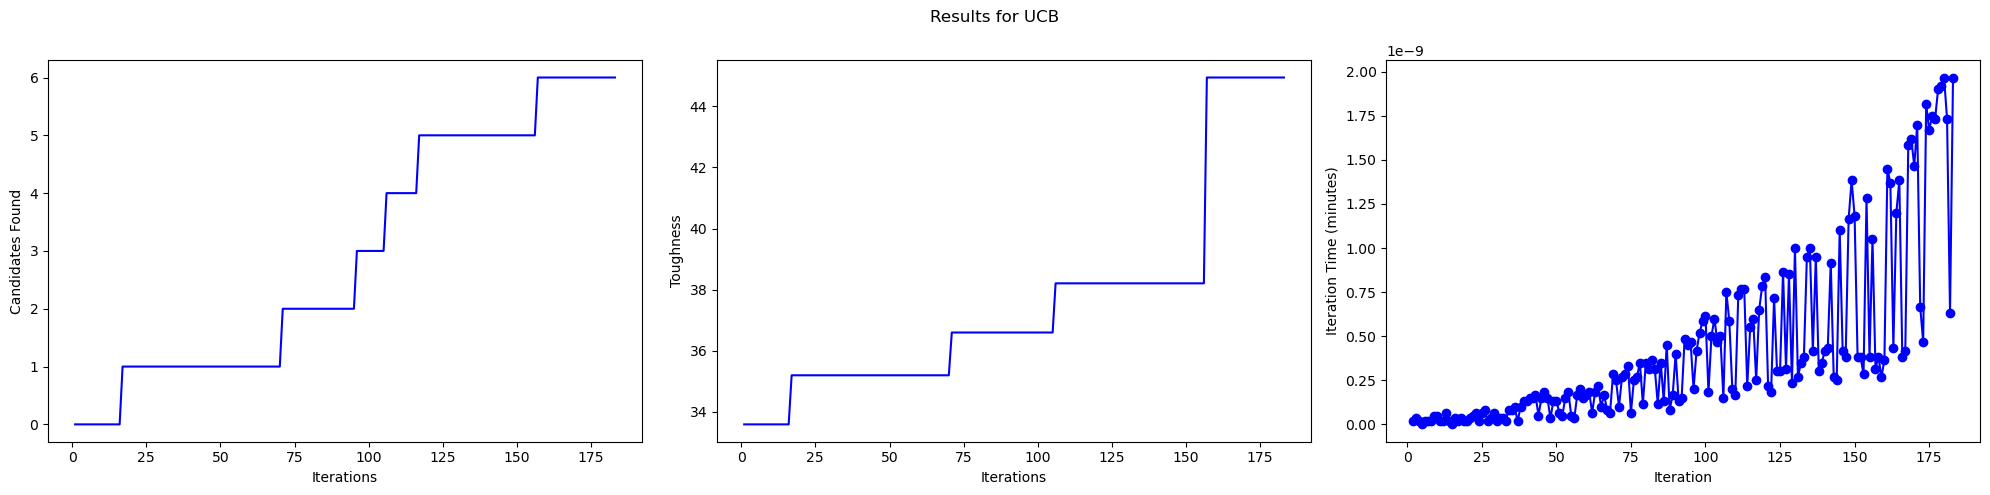

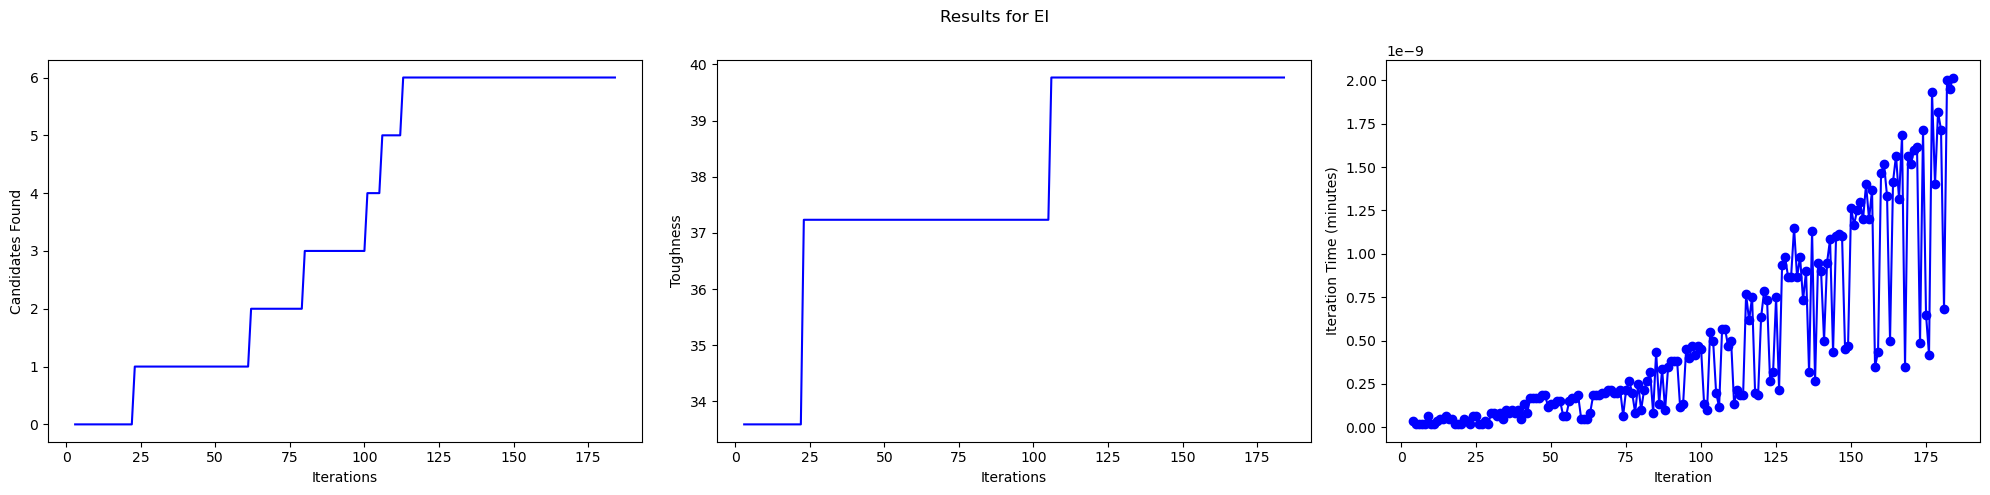

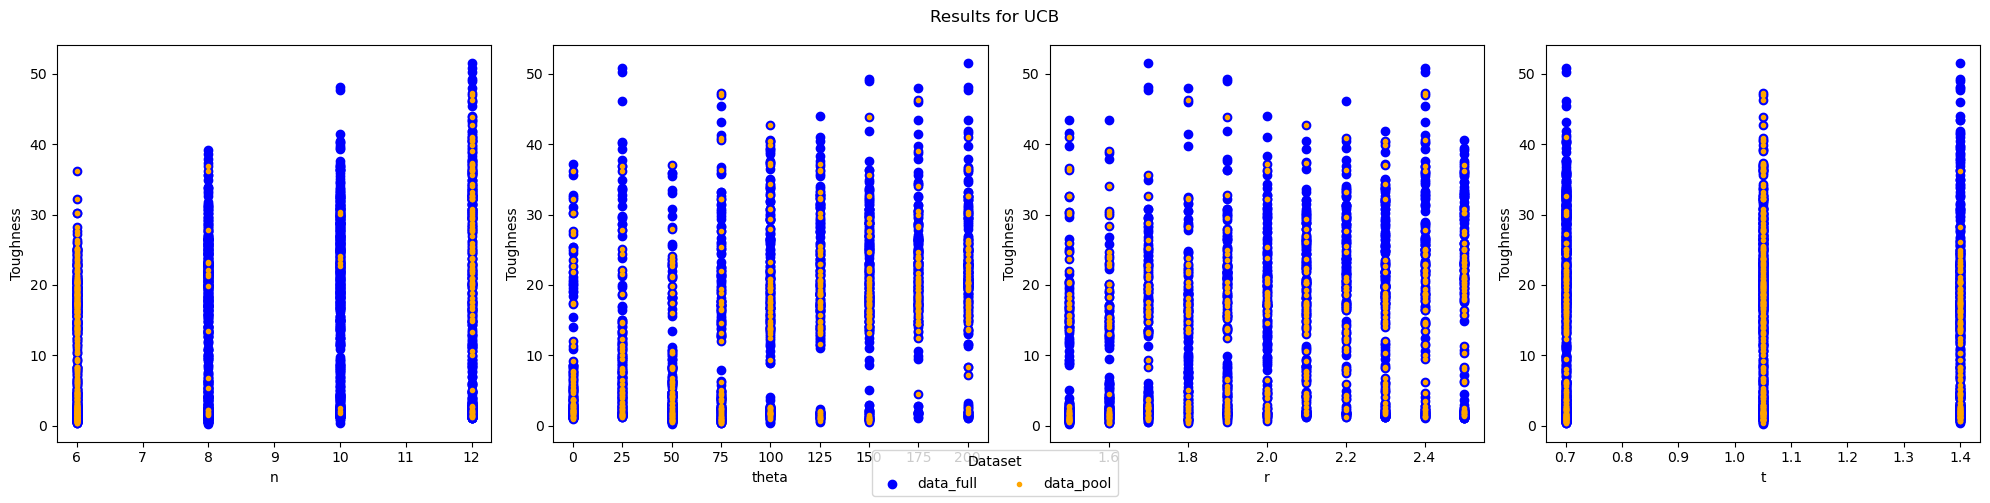

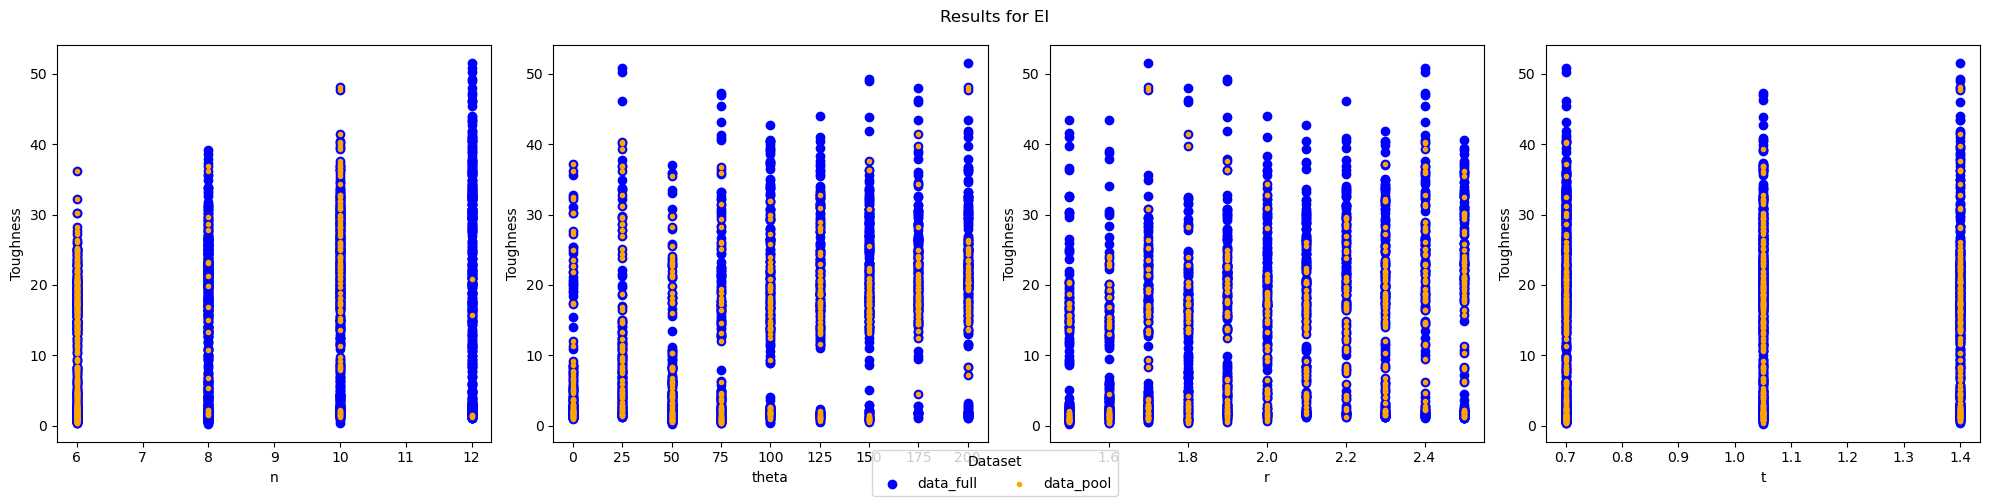

In [ ]:
"""
    Plot results
    Using functions defined above for making the plots
    Likely a better way to achieve this without haveing to reset data_pool and log_data each time
    but this is sufficient for now
"""

data_pool = UCB_data_pool
log_data = UCB_log_data
plot_iteration_metrics('UCB')

data_pool = EI_data_pool
log_data = EI_log_data
plot_iteration_metrics('EI')



data_pool = UCB_data_pool
log_data = UCB_log_data
plot_data_pool_results('UCB')

data_pool = EI_data_pool
log_data = EI_log_data
plot_data_pool_results('EI')


Finally provide some commentary on the performance of your optimization campaigns. What surprised you about the results? What would you do differently if you were to do this in a real experimental setting?

The EI acquisition function seemed to find maximum values for the n parameter, but picked almost no data from the n=12 parameter sets which is where almost all of the highest performing sets were.
This function also seems to have picked every single set where n=6 which was the worst performing value for that parameter.

The UCB acquisition function behaved similarly in that all the data at n=6 was looked at, but this one had many points from the n=12 parameter sets which is where most of the best performers were.




After running through this once with UCB kappa = 2 and EI xi = 0.01 I changed my xi to 0.1 to be more in line with the kappa of 2.  
  
It would be interesting to run a similar test but show the resultant plots for one of the models varying the kappa or xi values so we could see the effect on how the data was explored by the optimization.

Although it seemed that by 15 candidates from the top 5% for the termination concdition was likely 15 data points from the full dataset, I still ran my program with termination conditions to get 15 unique sets of parameters (would be 45 data points in the original set)  
The UCB ran for ~24 hours resulting in 405 iterations which were saved to a file for analysis.

I modified the conditions to terminate after 5 distinct candidates were found, but did not run that.
The data in the main export files already contains this data and can be scrubbed.

I plotted the data and it shows differences between the two methods.



By separating the program initialization from the optimization it is possible to run the optimization and then stop it and continue again.
For a cumbersome optimization is needed, it would likely be a good idea to append the data to output files during each loop iteration in case of crashes.